# The P-Dispersion (max-min-min) Problem

*Authors:* [Erin Olson](https://github.com/erinrolson), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)


When locating some types of facilites a primary objective may be to limit the potential for cascading adverse effects damage should one facility be damaged. Therefore, maximally dispersed arrangement would be the most beneficial. For example, power plants are generally not near other power plants as a precaution against localized damage or disablement during a natural disaster. To address this kind of scenarios with a mixed-integer program, Kuby (1987) described the following problem: _Locate $p$ facilities so that the minimum distance between any pair of facilities is maximized._

**P-Dispersion can be written as:**

\begin{equation*}
\textbf{Maximize } D 
\end{equation*}

___Subject to:___
\begin{equation*}
\sum_{i \in I} Y_i = p 
\end{equation*}

\begin{equation*}
D \leq d_{ij} + M (2 - Y_{i} - Y_{j}), \quad \forall i \in I \quad \forall j > i 
\end{equation*}

\begin{equation*}
Y_i = \{0,1\}, \quad \forall i \in I
\end{equation*}

___Where:___

\begin{array}{lll}
i,j & \small = & \textrm{index of potential facility sites} \\
n & \small = & \textrm{number of potential facility sites} \\
d_{ij} & \small = & \textrm{shortest path distance between sites } i \textrm{ and } j \\
M & \small = & \textrm{some large number; such that } M \geq \max_{ij}\{d_{ij}\} \\
p & \small = & \textrm{number of facilities to be located} \\
Y_i & \small = & \begin{cases} 
          1 \quad \text{if facility is located at node } i\\
          0 \quad \text{if otherwise} \\
       \end{cases} \end{array}

_The above fomulation was adapted from Maliszewski et al (2012), the original formulation is from Kuby (1987)._ 

This tutorial generates synthetic facility sites near a 10x10 lattice representing a gridded urban core. Three $p$-Dispersion instances are solved while varying parameters:

* `PDispersion.from_cost_matrix()` with network distance as the metric
* `PDispersion.from_geodataframe()` with euclidean distance as the metric
* `PDispersion.from_geodataframe()` with predefined facility locations and euclidean distance as the metric

Unlike other facility location models available in `spopt.locate`, the $p$-Dispersion problem does not take demand/client locations into consideration.

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2025-04-07T15:07:14.389023-04:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [2]:
import warnings

import geopandas
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy
import pulp
import shapely
from matplotlib.patches import Patch

import spopt
from spopt.locate import PDispersion, simulated_geo_points

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/spaghetti#649
    import spaghetti

%watermark -w
%watermark -iv

Watermark: 2.5.0

pulp      : 2.8.0
spaghetti : 1.7.6
shapely   : 2.1.0
spopt     : 0.6.2.dev3+g13ca45e
matplotlib: 3.10.1
numpy     : 2.2.4
geopandas : 1.0.1



Since the model needs a cost matrix (distance, time, etc.) we should define some variables. First we will assign some the number of facility locations followed by the random seed in order to reproduce the results. Finally, the solver, assigned below as `pulp.COIN_CMD`, is an interface to optimization solver developed by [COIN-OR](https://github.com/coin-or/Cbc). If you want to use another optimization interface, such as Gurobi or CPLEX, see this [guide](https://coin-

In [3]:
# quantity supply points
FACILITY_COUNT = 16

# number of candidate facilities in optimal solution
P_FACILITIES = 3

# random seeds for reproducibility
FACILITY_SEED = 6

# set the solver
solver = pulp.COIN_CMD(msg=False, warmStart=True)

## Lattice 10x10

Create a 10x10 lattice with 9 interior lines, both vertical and horizontal.

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

Transform the `spaghetti` instance into a geodataframe.

In [5]:
streets = spaghetti.element_as_gdf(ntw, arcs=True)

In [6]:
streets_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(streets["geometry"].buffer(0.5).union_all()),
    crs=streets.crs,
    columns=["geometry"],
)

Plotting the network created by `spaghetti` we can verify that it mimics a district with quarters and streets.

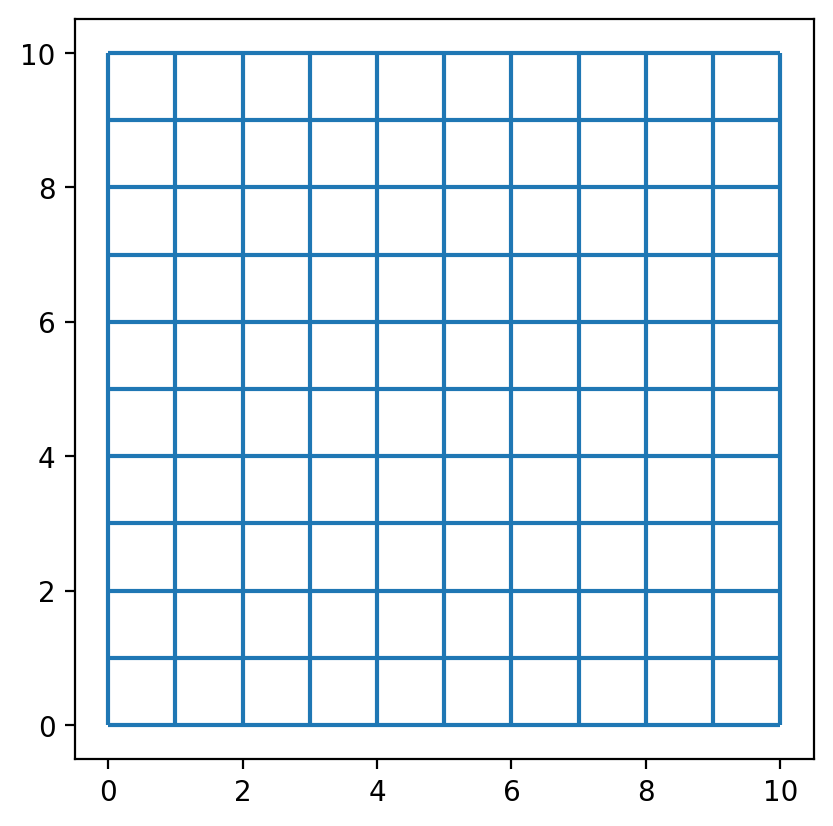

In [7]:
streets.plot();

## Simulate points in a network

The `simulated_geo_points` function simulates points near a network. In this case, it uses the 10x10 lattice network created using the `spaghetti` package. Below we use the function defined above and simulate the points near the lattice edges.

In [8]:
facility_points = simulated_geo_points(
    streets_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

Plotting the facility points we can see that the function generates dummy points to an area of 10x10, which is the area created by our lattice created on previous cells.

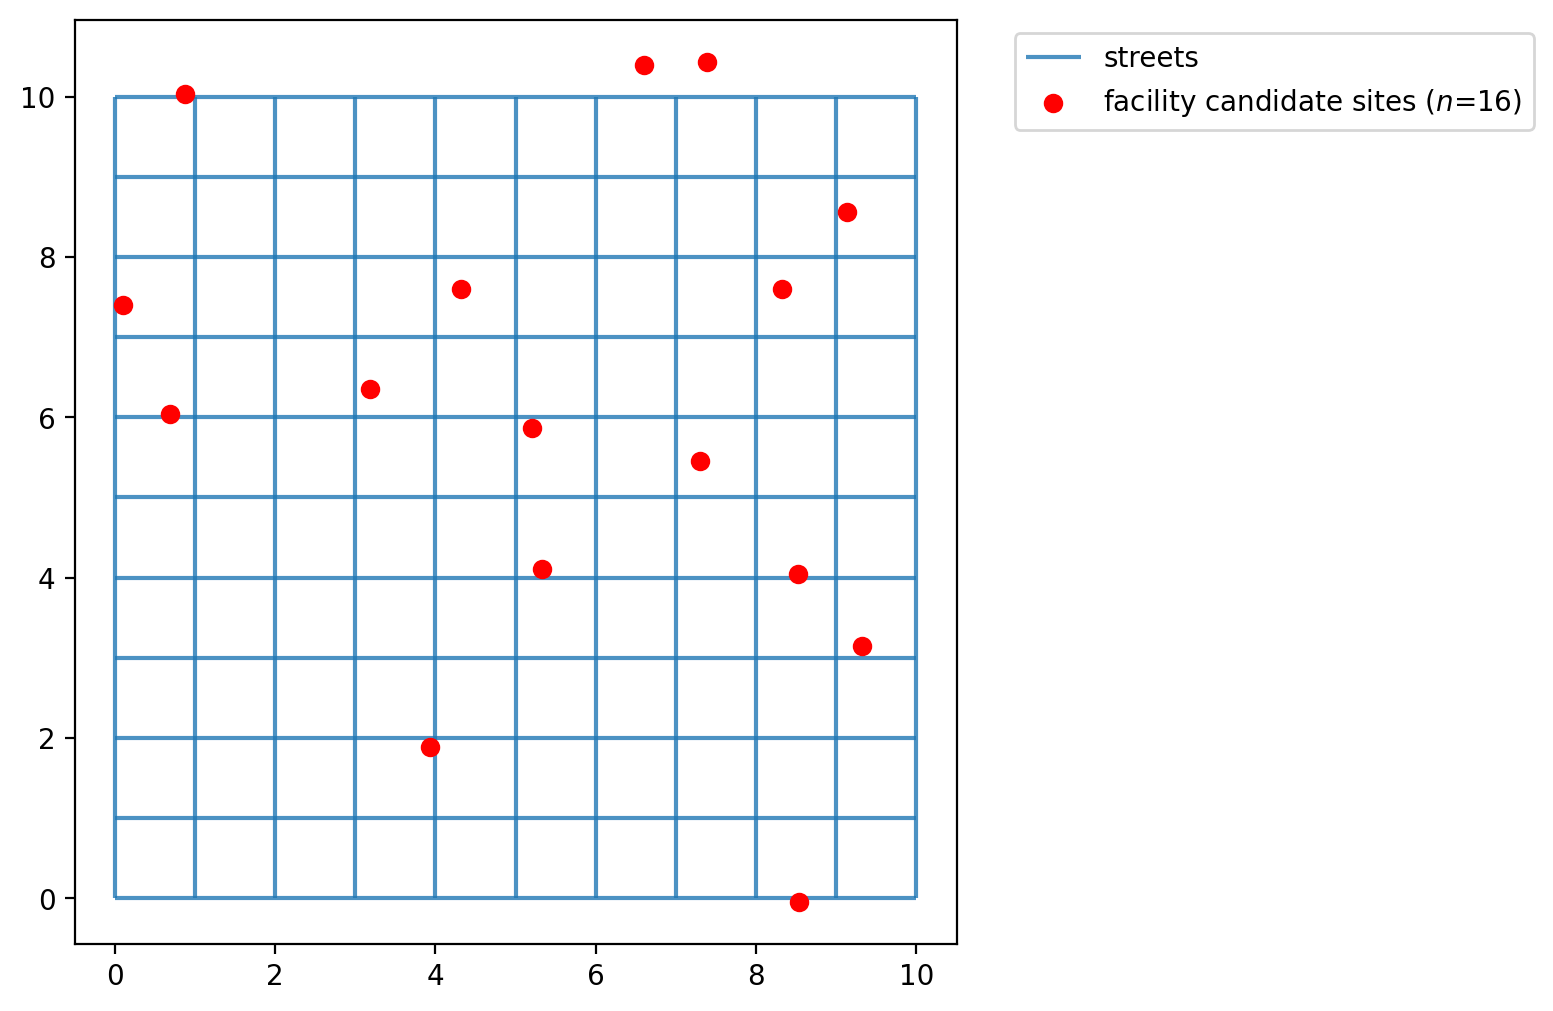

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facility_points.plot(
    ax=ax,
    color="red",
    zorder=2,
    label=f"facility candidate sites ($n$={FACILITY_COUNT})",
)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

## Assign simulated points network locations

The facility points do not adhere to network space. Calculating distances between them without restricting movement to the network results in a euclidean distances,'as the crow flies.' While this is acceptable for some applications, for others it is more realistic to consider network traversal (e.g. Does a mail carrier follow roads to deliver letters or fly from mailbox to mailbox?).

In our first example we will consider distance along the 10x10 lattice network created above. Therefore, we must first snap the observation points to the network prior to calculating a cost matrix.

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(ntw, pp_name="facilities", snapped=True)
facilities_snapped.drop(columns=["id", "comp_label"], inplace=True)

Now the plot seems more organized as the points occupy network space. The network is plotted below with the network locations of the facility points.

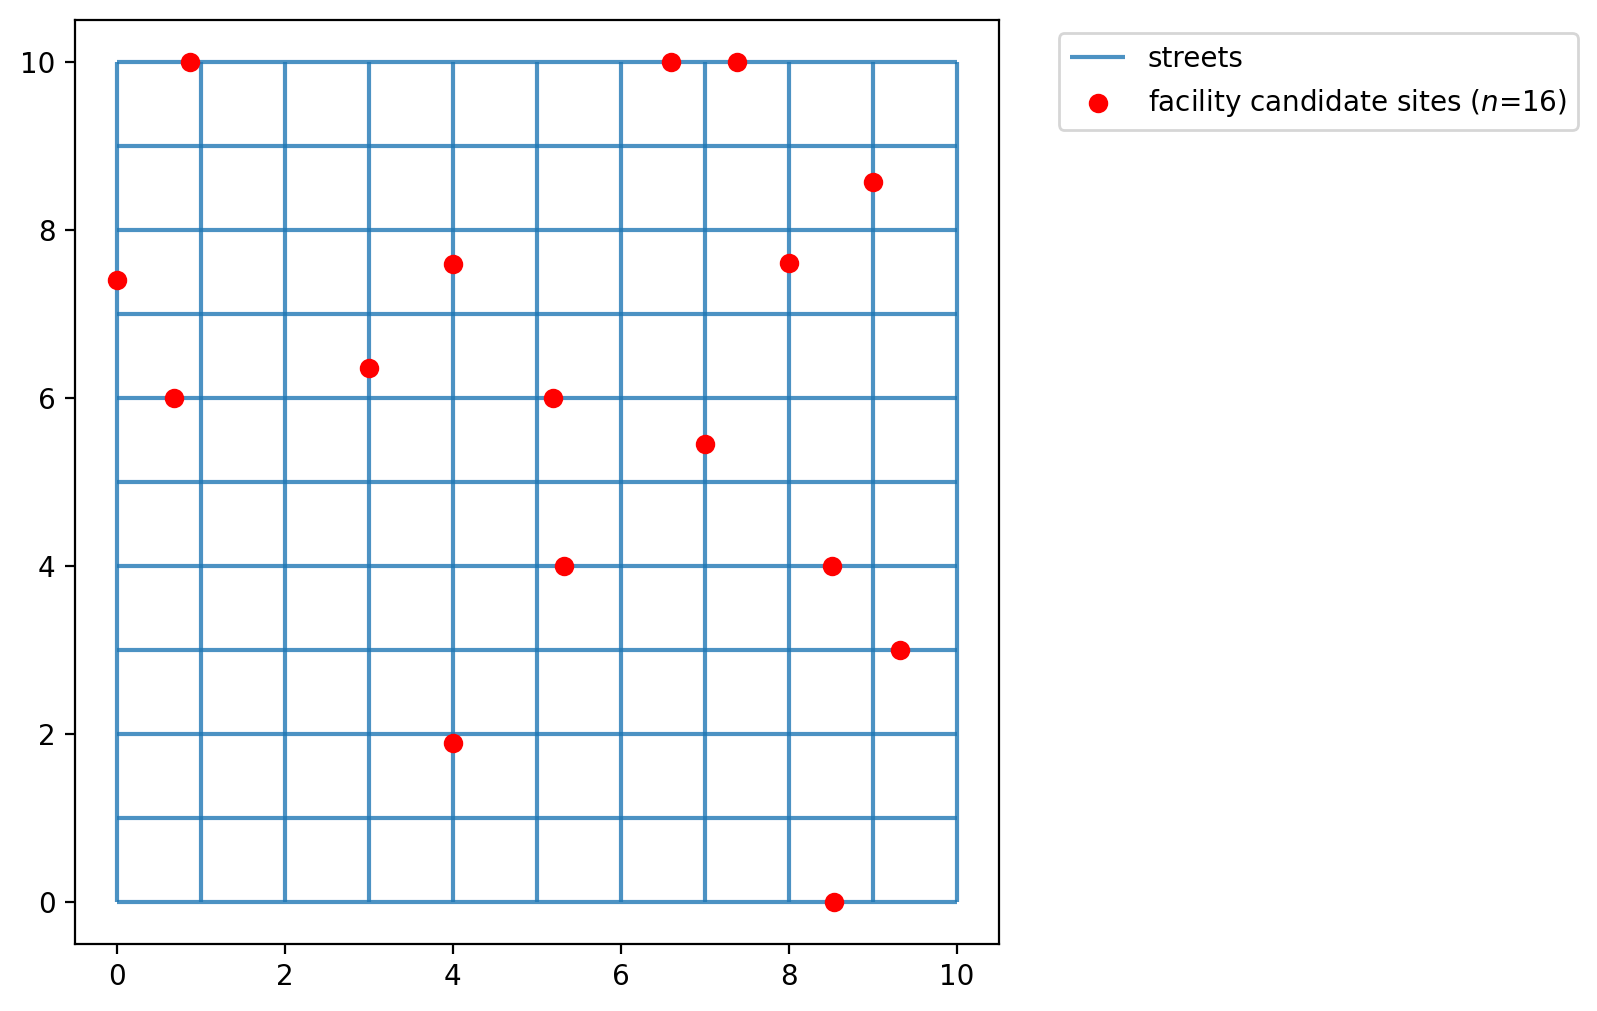

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facilities_snapped.plot(
    ax=ax,
    color="red",
    zorder=2,
    label=f"facility candidate sites ($n$={FACILITY_COUNT})",
)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

## Calculating the (network distance) cost matrix
Calculate the inter-facility network distance.

In [12]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["facilities"], fill_diagonal=0.0
)
cost_matrix.shape

(16, 16)

The expected result here is a network distance facilities points, in our case a 2D 16x16*** array.

In [13]:
cost_matrix[:5, :5]

array([[ 0.        ,  3.78794131, 11.63723819,  4.99347068,  9.66917542],
       [ 3.78794131,  0.        , 13.84929687,  7.20552937, 11.88123411],
       [11.63723819, 13.84929687,  0.        ,  6.6437675 ,  2.66349027],
       [ 4.99347068,  7.20552937,  6.6437675 ,  0.        ,  4.67570474],
       [ 9.66917542, 11.88123411,  2.66349027,  4.67570474,  0.        ]])

In [14]:
cost_matrix[-5:, -5:]

array([[ 0.        ,  3.15016768,  9.526461  ,  9.71401032,  3.00949261],
       [ 3.15016768,  0.        , 10.67662868,  6.56384263,  4.93972891],
       [ 9.526461  , 10.67662868,  0.        , 11.24047132,  6.51696839],
       [ 9.71401032,  6.56384263, 11.24047132,  0.        , 11.50357155],
       [ 3.00949261,  4.93972891,  6.51696839, 11.50357155,  0.        ]])

With ``PDispersion.from_cost_matrix`` we model the $p$-dispersion problem to maximize the minimum inter-facility 
cost (in this case network distance in generic units, as calculated above) while siting $p$ facilites.

In [15]:
pdispersion_from_cm = PDispersion.from_cost_matrix(
    cost_matrix, P_FACILITIES, name="p-dispersion-network-distance"
)
pdispersion_from_cm = pdispersion_from_cm.solve(solver)
pdispersion_from_cm

In [16]:
pdispersion_obj = round(pdispersion_from_cm.problem.objective.value(), 3)
print(
    "A maximized minimum inter-facility distance between any two sited candiate "
    f"facilities of {pdispersion_obj} distance units is observed while siting "
    f"facilities at {P_FACILITIES} of the available {FACILITY_COUNT} locations."
)

A maximized minimum inter-facility distance between any two sited candiate facilities of 10.706 distance units is observed while siting facilities at 3 of the available 16 locations.


Define the decision variable names used for mapping later.

In [17]:
facility_points["dv"] = pdispersion_from_cm.fac_vars
facility_points["dv"] = facility_points["dv"].map(lambda x: x.name.replace("_", ""))
facilities_snapped["dv"] = facility_points["dv"]
facility_points

,geometry,dv
0,POINT (9.32146 3.15178),y0
1,POINT (8.53352 -0.04134),y1
2,POINT (0.68422 6.04557),y2
3,POINT (5.32799 4.10688),y3
4,POINT (3.18949 6.34771),y4
5,POINT (4.31956 7.5947),y5
6,POINT (5.1984 5.86744),y6
7,POINT (6.59891 10.39247),y7
8,POINT (8.51844 4.04521),y8
9,POINT (9.13894 8.56135),y9


## Calculating euclidean distance from a `GeoDataFrame`

With ``PDispersion.from_cost_matrix`` we model the $p$-dispersion problem to maximize the minimum inter-facility 
cost (in this case euclidean distance in generic units) while siting $p$ facilites.

Next we will solve the $p$-dispersion problem considering all candidate locations for potential selection.

In [18]:
distance_metric = "euclidean"
pdispersion_from_gdf = PDispersion.from_geodataframe(
    facilities_snapped,
    "geometry",
    P_FACILITIES,
    distance_metric=distance_metric,
    name=f"p-dispersion-{distance_metric}-distance",
)
pdispersion_from_gdf = pdispersion_from_gdf.solve(solver)
pdispersion_from_gdf

In [19]:
pdispersion_obj = round(pdispersion_from_gdf.problem.objective.value(), 3)
print(
    "A maximized minimum inter-facility distance between any two sited candiate "
    f"facilities of {pdispersion_obj} distance units is observed while siting "
    f"facilities at {P_FACILITIES} of the available {FACILITY_COUNT} locations."
)

A maximized minimum inter-facility distance between any two sited candiate facilities of 8.574 distance units is observed while siting facilities at 3 of the available 16 locations.


However, in many real world applications there may already be existing facility locations with the goal being to add one or more new facilities. Here we will define facilites $y_{11}$ and $y_{12}$ as already existing (they must be present in the model solution). This will lead to a sub-optimal solution.

***Important:*** The facilities in `"predefined_loc"` are a binary array where `1` means the associated location must appear in the solution.

In [20]:
facility_points["predefined_loc"] = 0
facility_points.loc[(11, 12), "predefined_loc"] = 1
facilities_snapped["predefined_loc"] = facility_points["predefined_loc"]
facility_points

,geometry,dv,predefined_loc
0,POINT (9.32146 3.15178),y0,0
1,POINT (8.53352 -0.04134),y1,0
2,POINT (0.68422 6.04557),y2,0
3,POINT (5.32799 4.10688),y3,0
4,POINT (3.18949 6.34771),y4,0
5,POINT (4.31956 7.5947),y5,0
6,POINT (5.1984 5.86744),y6,0
7,POINT (6.59891 10.39247),y7,0
8,POINT (8.51844 4.04521),y8,0
9,POINT (9.13894 8.56135),y9,0


In [21]:
pdispersion_from_gdf_pre = PDispersion.from_geodataframe(
    facilities_snapped,
    "geometry",
    P_FACILITIES,
    predefined_facility_col="predefined_loc",
    distance_metric=distance_metric,
    name=f"p-dispersion-{distance_metric}-distance-predefined",
)
pdispersion_from_gdf_pre = pdispersion_from_gdf_pre.solve(solver)
pdispersion_from_gdf_pre

In [22]:
pdispersion_obj = round(pdispersion_from_gdf_pre.problem.objective.value(), 3)
print(
    "A maximized minimum inter-facility distance between any two sited candiate "
    f"facilities of {pdispersion_obj} distance units is observed while siting "
    f"facilities at {P_FACILITIES} of the available {FACILITY_COUNT} locations."
)

A maximized minimum inter-facility distance between any two sited candiate facilities of 2.371 distance units is observed while siting facilities at 3 of the available 16 locations.


## Plotting the results

The two cells below describe the plotting of the results. For each method from the `PDispersion` class (`.from_cost_matrix()`, `.from_geodataframe()`) there is a plot displaying the facility site that was selected with a colored star.

In [23]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid'}

In [24]:
def plot_results(model, p, facs, clis=None, ax=None):
    """Visualize optimal solution sets and context."""
    if not ax:
        multi_plot = False
        fig, ax = plt.subplots(figsize=(6, 6))
        markersize, markersize_factor = 4, 4
    else:
        ax.axis("off")
        multi_plot = True
        markersize, markersize_factor = 2, 2

    ax.set_title(model.name, fontsize=15)
    facility_count = len(model.fac_vars)
    fac_sites = {}

    plot_clis = isinstance(clis, geopandas.GeoDataFrame)
    if plot_clis:
        cli_points = {}

    for i, dv in enumerate(model.fac_vars):
        if dv.varValue:
            dv, predef = facs.loc[i, ["dv", "predefined_loc"]]
            fac_sites[dv] = [i, predef]
            if plot_clis:
                geom = clis.iloc[model.fac2cli[i]]["geometry"]
                cli_points[dv] = geom

    # study area and legend entries initialization
    streets.plot(ax=ax, alpha=1, color="black", zorder=1)
    legend_elements = [mlines.Line2D([], [], color="black", label="streets")]

    if plot_clis and model.name.startswith("mclp"):
        # any clients that not asscociated with a facility
        c = "k"
        if model.n_cli_uncov:
            idx = [i for i, v in enumerate(model.cli2fac) if len(v) == 0]
            pnt_kws = {
                "ax": ax,
                "fc": c,
                "ec": c,
                "marker": "s",
                "markersize": 7,
                "zorder": 2,
            }
            clis.iloc[idx].plot(**pnt_kws)
        _label = f"Demand sites not covered ($n$={model.n_cli_uncov})"
        _mkws = {
            "marker": "s",
            "markerfacecolor": c,
            "markeredgecolor": c,
            "linewidth": 0,
        }
        legend_elements.append(mlines.Line2D([], [], ms=3, label=_label, **_mkws))

    # all candidate facilities
    facs.plot(ax=ax, fc="brown", marker="*", markersize=80, zorder=8)
    _label = f"Facility sites ($n$={facility_count})"
    _mkws = {"marker": "*", "markerfacecolor": "brown", "markeredgecolor": "brown"}
    legend_elements.append(mlines.Line2D([], [], ms=7, lw=0, label=_label, **_mkws))

    # client-facility symbology and legend entries
    zorder = 4
    for fname, (fac, predef) in fac_sites.items():
        cset = dv_colors[fname]

        if plot_clis:
            # clients
            geoms = cli_points[fname]
            gdf = geopandas.GeoDataFrame(geoms)
            gdf.plot(ax=ax, zorder=zorder, ec="k", fc=cset, markersize=100 * markersize)
            _label = f"Demand sites covered by {fname}"
            _mkws = {
                "markerfacecolor": cset,
                "markeredgecolor": "k",
                "ms": markersize + 7,
            }
            legend_elements.append(
                mlines.Line2D([], [], marker="o", lw=0, label=_label, **_mkws)
            )
        # facilities
        ec = "k"
        lw = 2
        predef_label = "predefined"
        if model.name.endswith(predef_label) and predef:
            ec = "r"
            lw = 3
            fname += f" ({predef_label})"
        facs.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec=ec, lw=lw
        )
        _mkws = {"markerfacecolor": cset, "markeredgecolor": ec, "markeredgewidth": lw}
        legend_elements.append(
            mlines.Line2D([], [], marker="*", ms=20, lw=0, label=fname, **_mkws)
        )
        # increment zorder up and markersize down for stacked client symbology
        zorder += 1
        if plot_clis:
            markersize -= markersize_factor / p

    if not multi_plot:
        # legend
        kws = {"loc": "upper left", "bbox_to_anchor": (1.05, 0.7)}
        plt.legend(handles=legend_elements, **kws)

### P-Dispersion built from cost matrix (network distance)

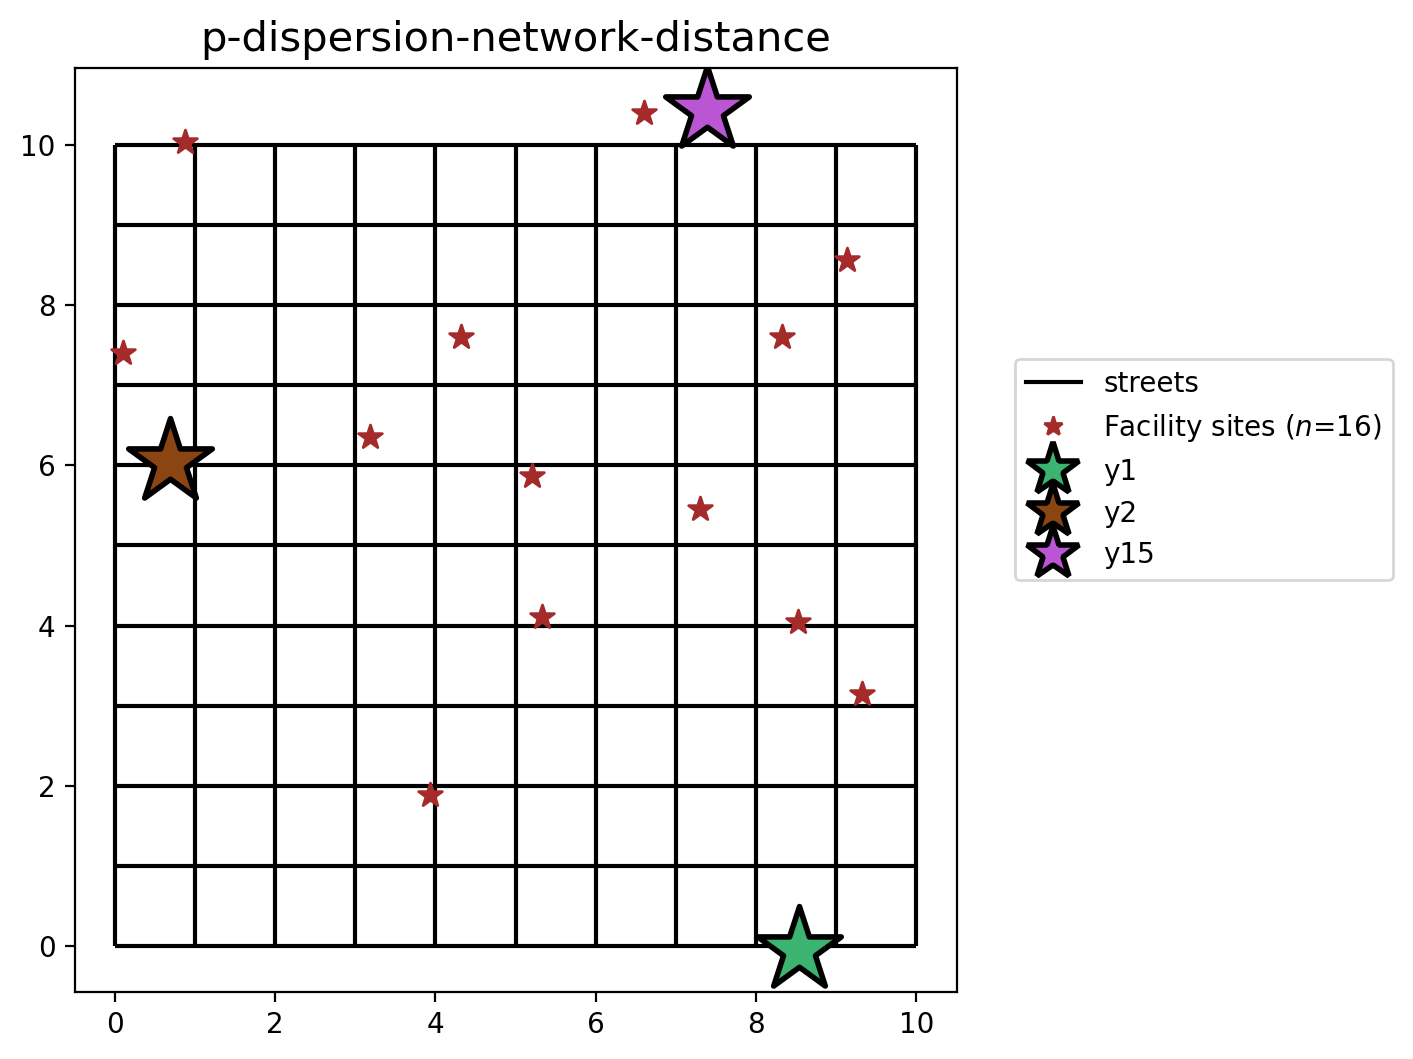

In [25]:
plot_results(pdispersion_from_cm, P_FACILITIES, facility_points)

### P-Dispersion built from geodataframe (euclidean distance)

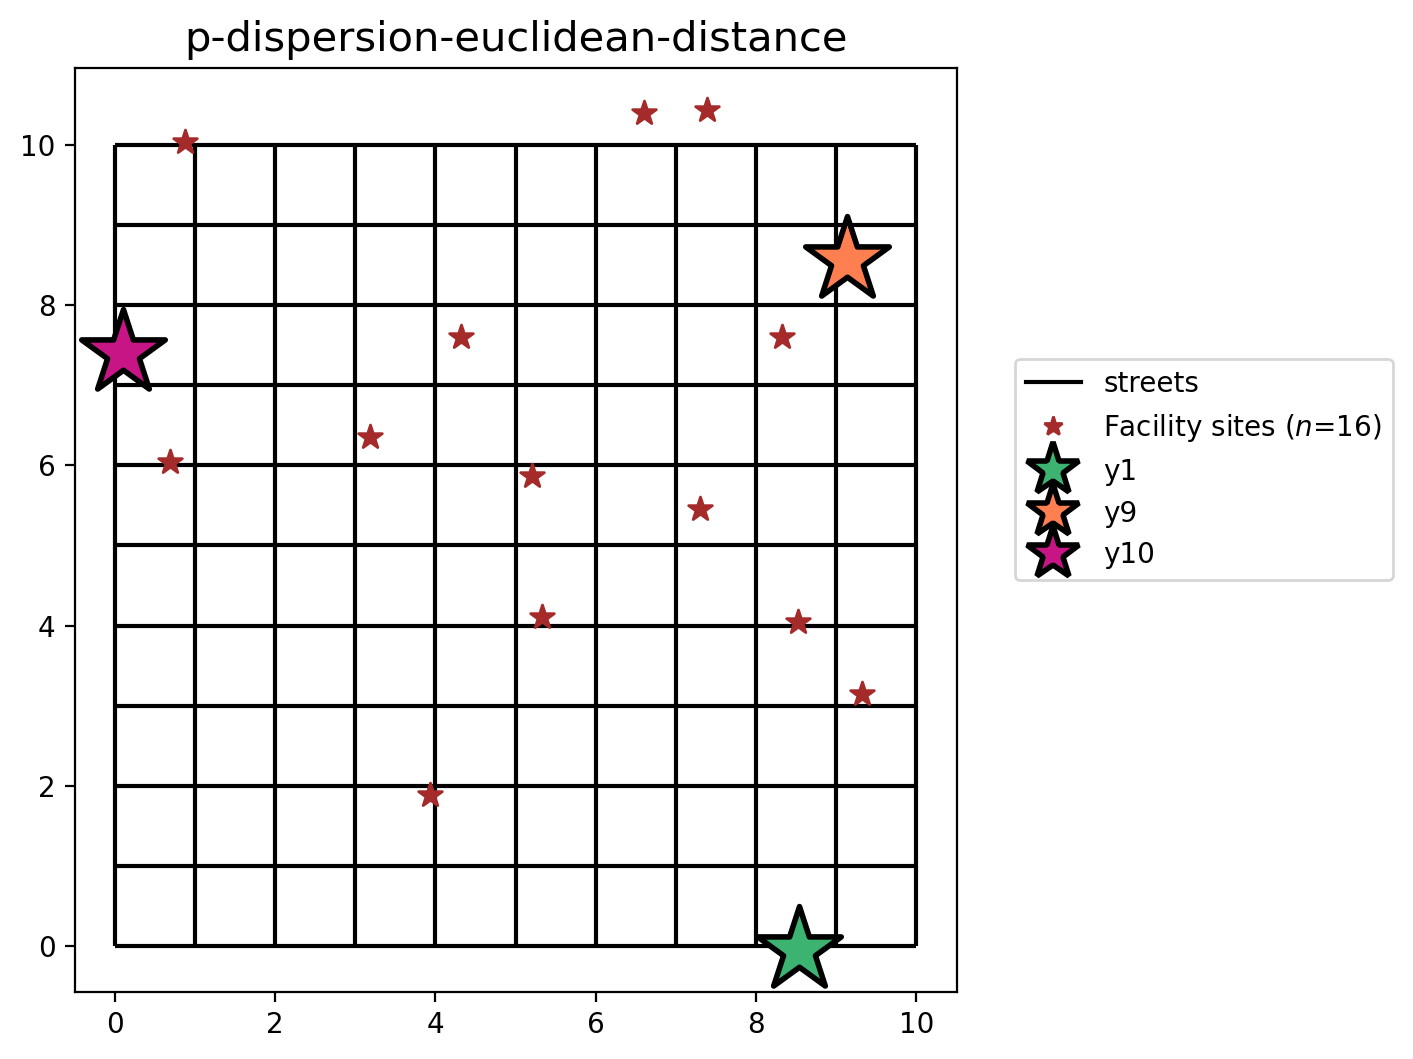

In [26]:
plot_results(pdispersion_from_gdf, P_FACILITIES, facility_points)

### P-Dispersion with preselected facilities (euclidean distance)

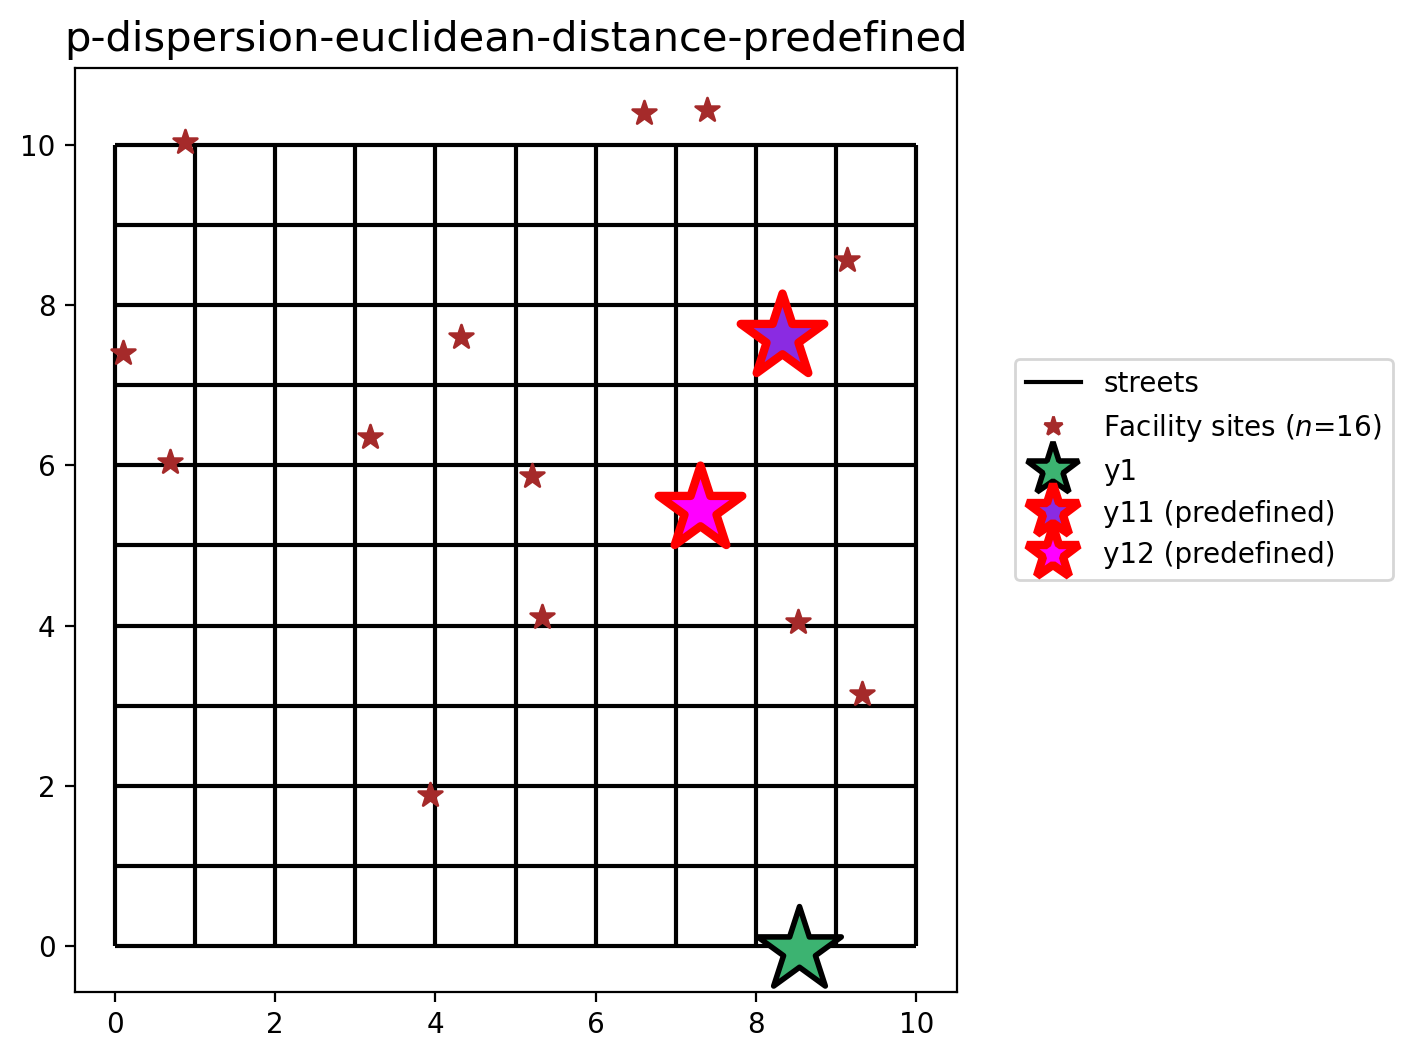

In [27]:
plot_results(pdispersion_from_gdf_pre, P_FACILITIES, facility_points)

-----------------------------------

## Comparing solution from varied metrics

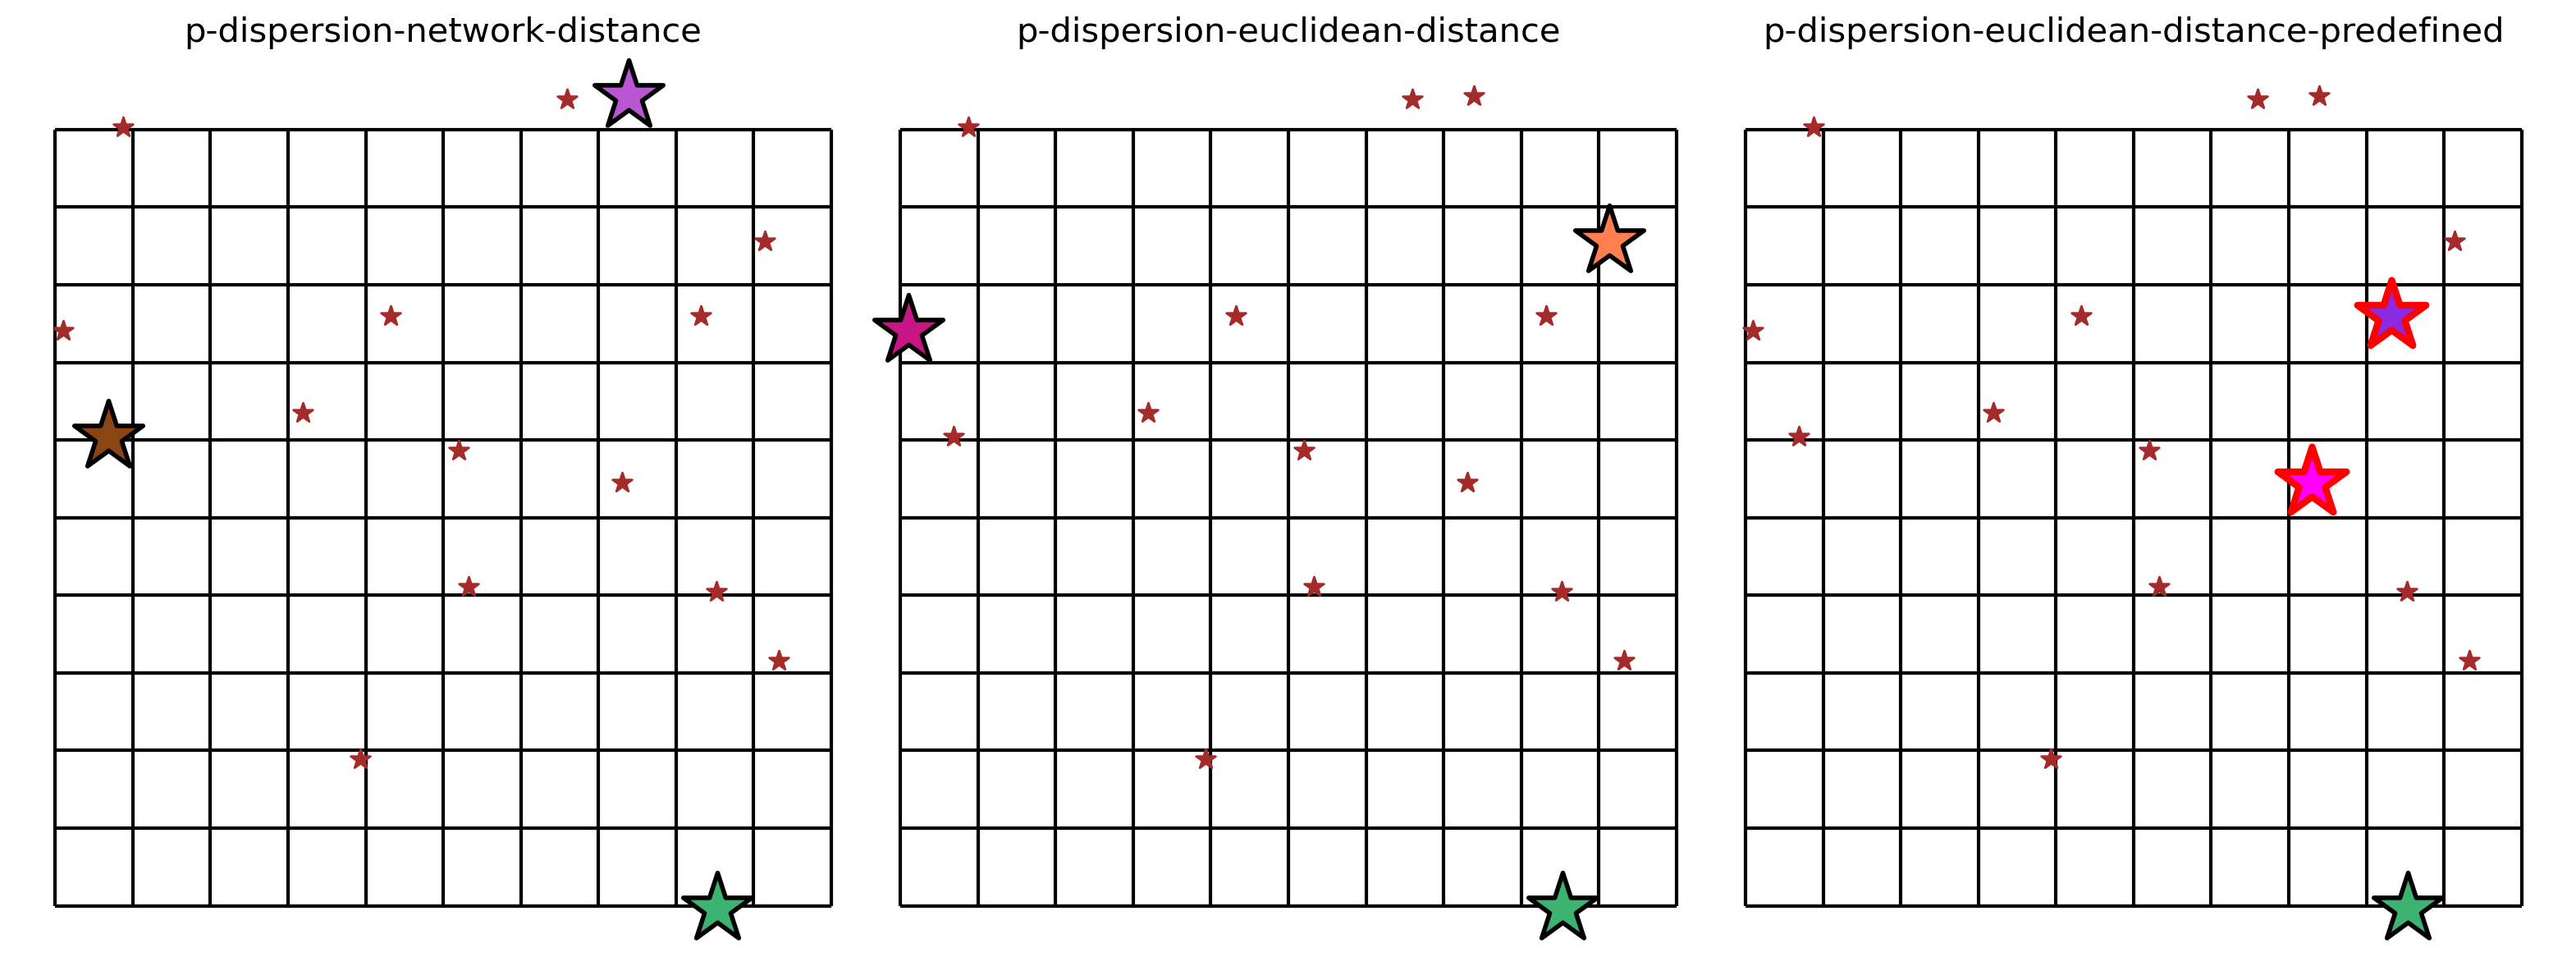

In [28]:
fig, axarr = plt.subplots(1, 3, figsize=(20, 10))
fig.subplots_adjust(wspace=-0.01)
for i, m in enumerate(
    [pdispersion_from_cm, pdispersion_from_gdf, pdispersion_from_gdf_pre]
):
    plot_results(m, P_FACILITIES, facility_points, ax=axarr[i])

All 3 solutions to the $p$-dispersion problem vary spatially, as seen above, but they also all include facility $y_1$ since it is the most isolated location. A good demonstration of the intended results of dispersion can be seen in the first two models, `P-Dispersion-network-distance` and `P-Dispersion-euclidean-distance`, where the selected candidate facilites are arranged to form pseudo-equilateral triangles. Of course, the `P-Dispersion-euclidean-distance-predefined` model does not follow this pattern due to the stipulation that facilities $y_{11}$ and $y_{12}$ be included in the optimal solution.


## References

- [Kuby, Michael J. 1987. Programming Models for Facility Dispersion: The p-Dispersion and Maximum Dispersion Problems. Geographical Analysis, 19, 315–329.](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1538-4632.1987.tb00133.x)
- [Maliszewski, Paul J., Michael J. Kuby, and Mark W. Horner. 2012. A comparison of multi-objective spatial dispersion models for managing critical assets in urban areas. Computers, Environment and Urban Systems. 36 (4):331-341.](https://www.sciencedirect.com/science/article/pii/S0198971511001293?via%3Dihub)